import libraries

In [2]:
import pandas as pd
import numpy as np

data

In [3]:
points_geo = pd.read_csv('df_resolute_CLEANED_4IQR_4PREP_priceperm2IQR_prep.csv')
points_geo.drop(['PriceEuro','NAME_LATIN', 'longitude', 'latitude'], axis=1, inplace=True)

In [4]:
points_geo.PricePerM2.describe()

count    76000.000000
mean       931.539874
std        772.606003
min          0.400000
25%        260.000000
50%        781.000000
75%       1389.000000
max       3243.000000
Name: PricePerM2, dtype: float64

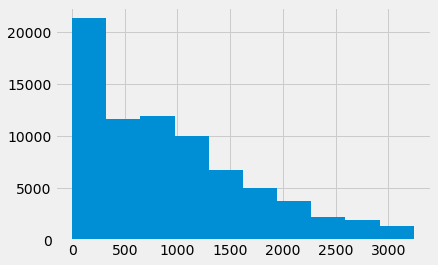

In [32]:
points_geo.PricePerM2.hist()

In [5]:
# n_points_geo.info()

pick property type

In [5]:
n_points_geo = points_geo[points_geo.property_land==1]
# n_points_geo = points_geo[points_geo.property_residential==1]
#n_points_geo = points_geo[points_geo.property_business==1]

In [6]:
n_points_geo.reset_index(drop=True,inplace=True)
n_points_geo.drop(['Rooms', 'Levels', 'property_business', 'property_land',
                   'property_other', 'property_residential'], axis=1, inplace=True)

/home/lefteris/anaconda3/envs/resolute/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


random forest 

In [7]:
gps_hot = n_points_geo.copy()

In [8]:
gps_predict_label = 'PricePerM2'
gps_test_list = [x for x in gps_hot.columns if x!=gps_predict_label]

In [9]:
# y is the values we want to predict
y = gps_hot[gps_predict_label].values
# OR
# Labels are the values we want to predict
labels = np.array(gps_hot[gps_predict_label])

# Convert to numpy array
X = gps_hot[gps_test_list].values
# OR
# Convert to numpy array
gps_array = np.array(gps_hot[gps_test_list])

split dataset into train and test

In [10]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# # Split the data into training and testing sets
# train_features, test_features, train_labels, test_labels =\
#     train_test_split(gps_array, labels, test_size = 0.20) # , random_state = 42

#OR

# Split the data into training and testing sets
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size = 0.20) # , random_state = 42

In [11]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (27519, 11)
Training Labels Shape: (27519,)
Testing Features Shape: (6880, 11)
Testing Labels Shape: (6880,)


train

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 100 decision trees
reg = RandomForestRegressor(n_estimators = 100, n_jobs=-1) # , random_state = 42

# Train the model on training data
reg.fit(X_train, y_train) # OR train_features, train_labels

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

predict

In [13]:
# Use the forest's predict method on the test data
y_pred = reg.predict(X_test) #OR test_features

metrics

In [14]:
result = pd.DataFrame(y_pred,y_test).reset_index().rename(columns={'index':'real_cnt',0:'pred_cnt'})
result.sample(5)

,real_cnt,pred_cnt
3961,889.0,1325.435683
6786,28.0,24.772500
5071,184.0,188.580833
6601,99.0,122.965556
4572,203.0,180.020000


In [15]:
from sklearn import metrics

print('error units: Euro PerM2')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

error units: Euro PerM2
Mean Absolute Error: 138.67184484368758
Mean Squared Error: 56529.59195261237
Root Mean Squared Error: 237.7595254718775


important features

In [16]:
# Get numerical feature importances
importances = list(reg.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(gps_array, round(importance, 3)) for gps_array, importance in zip(gps_test_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: pop_densi            Importance: 0.459
Variable: Area_sqm             Importance: 0.252
Variable: oiki_densi           Importance: 0.103
Variable: geohash_lat          Importance: 0.085
Variable: geohash_lng          Importance: 0.071
Variable: age                  Importance: 0.026
Variable: near_city            Importance: 0.002
Variable: near_coast           Importance: 0.001
Variable: near_beach           Importance: 0.001
Variable: Bedrooms             Importance: 0.0
Variable: Bathrooms            Importance: 0.0


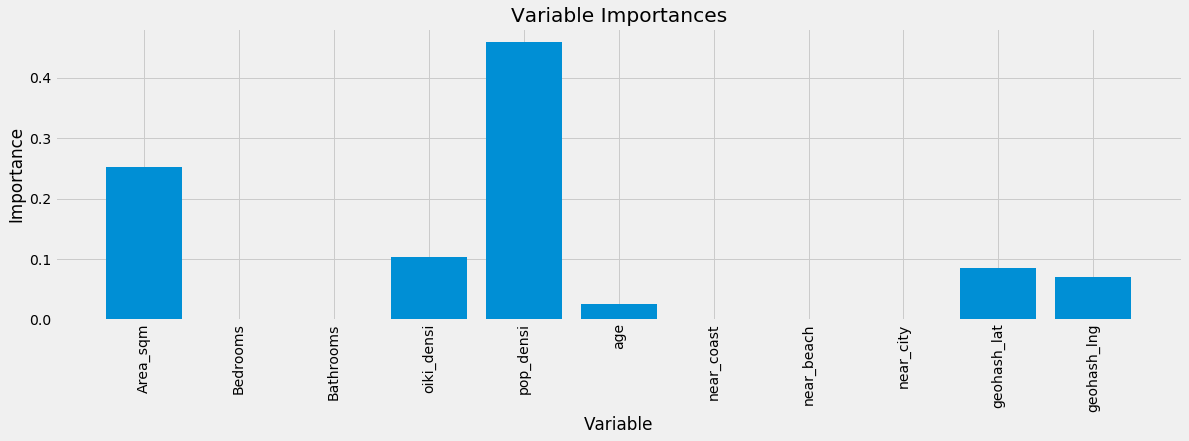

In [17]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# set the size of figure
f, ax = plt.subplots(figsize=(18,5))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, gps_test_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

check predict

In [18]:
df_to_predict_df = gps_hot[(gps_hot['Bedrooms']==3) &
                               (gps_hot['Area_sqm'] > 100)]

test_value = df_to_predict_df[gps_test_list].values
test_pred_value = df_to_predict_df[[gps_predict_label]].values

In [21]:
pred_value = reg.predict(test_value)

In [22]:
# pd.DataFrame(test_pred_value,pred_value)
df = pd.DataFrame({'pred_cnt':pred_value})
df['actual_cnt'] = test_pred_value

In [40]:
df

,pred_cnt,actual_cnt
0,2275.150000,2500.0
1,2901.270000,3000.0
2,2568.780000,2439.0
3,2808.552500,2988.0
4,2753.953000,2625.0
5,1940.930000,1885.0
6,2923.873000,3214.0
7,1806.480000,1885.0
8,1316.550000,887.0
9,1329.320000,1000.0
